# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Признаки


- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


Целевой признак
- Price — цена (евро)

In [1]:
##Переменные

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [2]:
!pip install scikit-learn==1.1.3 -q
!pip install missingno -q
!pip install phik -q
!pip install shap -q
!pip install optuna-integration[sklearn] -q
!pip install lightgbm -q
!pip install python-Levenshtein -q

In [3]:
import pandas as pd
import Levenshtein
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder, 
                                   MinMaxScaler, 
                                   OrdinalEncoder)
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import phik
import shap
from phik import resources, phik_matrix
import missingno as msno
import optuna
from optuna.integration import OptunaSearchCV 
from optuna import distributions
import lightgbm as lgb
import time

## Подготовка данных

In [4]:
df_base = pd.read_csv('/datasets/autos.csv')
df_base.name = 'df_base'
pd.set_option('display.max_columns', None)

display(df_base.sample(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
310434,2016-04-04 19:56:36,850,wagon,2000,manual,64,other,90000,1,petrol,kia,no,2016-04-04 00:00:00,0,60549,2016-04-05 12:24:41
149382,2016-03-23 15:51:31,1999,bus,2001,NaN,0,NaN,150000,8,lpg,renault,no,2016-03-23 00:00:00,0,23701,2016-03-24 23:45:32
336342,2016-04-03 21:44:52,14800,convertible,2006,auto,192,3er,100000,7,petrol,bmw,no,2016-04-03 00:00:00,0,81245,2016-04-05 22:44:41
316796,2016-03-30 20:36:17,6899,wagon,2010,manual,69,fabia,90000,3,gasoline,skoda,no,2016-03-30 00:00:00,0,32609,2016-04-05 11:46:18
196075,2016-03-12 18:46:22,4800,bus,2006,manual,105,caddy,150000,0,NaN,volkswagen,no,2016-03-12 00:00:00,0,94535,2016-03-12 18:46:22
68295,2016-03-12 16:45:52,6900,sedan,2007,manual,122,1er,150000,3,petrol,bmw,no,2016-03-12 00:00:00,0,34414,2016-03-12 16:45:52
287309,2016-03-31 10:49:33,4800,wagon,2009,manual,110,passat,125000,3,gasoline,volkswagen,no,2016-03-31 00:00:00,0,72636,2016-03-31 10:49:33
89212,2016-03-14 20:51:18,500,sedan,2000,NaN,116,other,150000,0,NaN,hyundai,yes,2016-03-14 00:00:00,0,18320,2016-04-04 08:47:01
310875,2016-03-30 18:40:02,4100,small,2008,manual,120,2_reihe,150000,3,petrol,peugeot,no,2016-03-30 00:00:00,0,42105,2016-04-07 09:44:37
153286,2016-03-12 13:45:28,500,wagon,1997,auto,194,NaN,150000,4,petrol,bmw,NaN,2016-03-12 00:00:00,0,4329,2016-03-12 13:45:28


In [5]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df_base.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<AxesSubplot:>

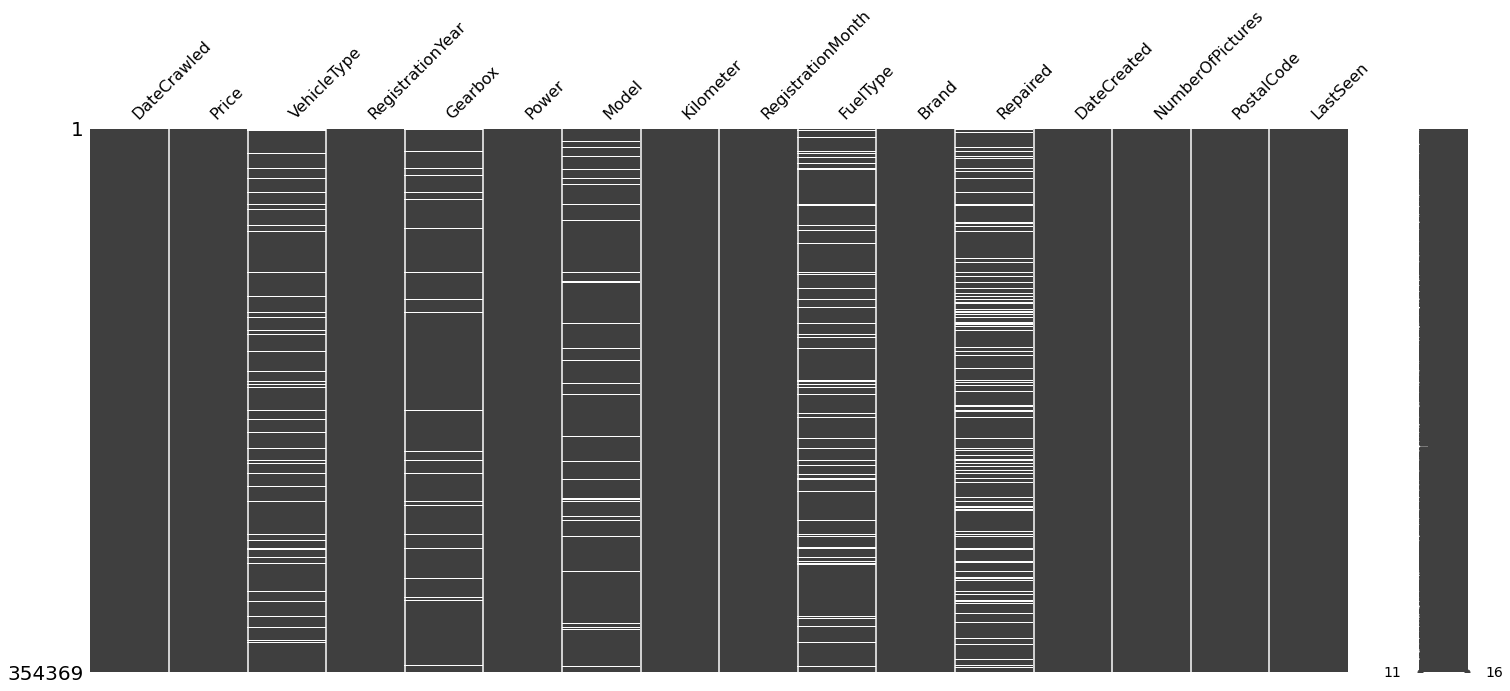

In [7]:
msno.matrix(df_base)

<AxesSubplot:>

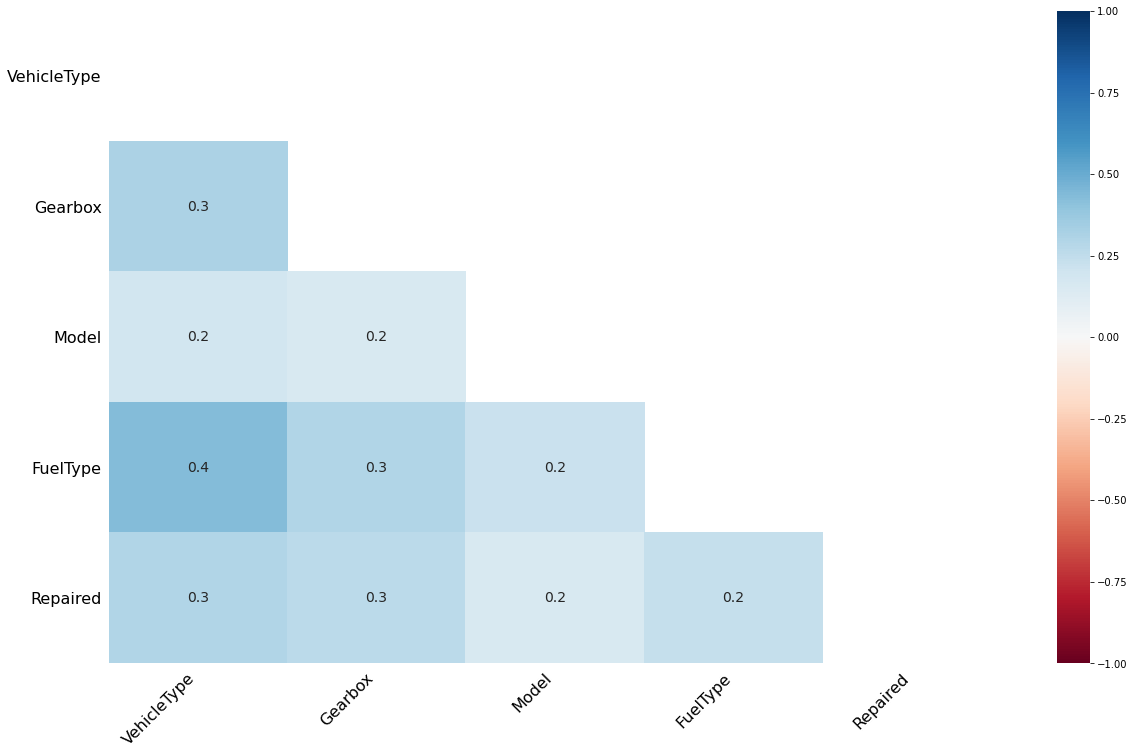

In [8]:
msno.heatmap(df_base)

### Выводы

- с данными ознакомились, для определения целевого признака понадобятся далеко не все входные, от ненужных избавимся позже;
- есть пропуски в VehicleType, Gearbox, Model, FuelType, Repaired и между собой они не связаны - будем разбираться подробно в предподготовке;
- согласно анализу describe в нашей таблице присутствую выбросы/аномалии. Также будем смотреть в предподготовке;
- проведу проверку на явные и неявные дубликаты и поищу опечатки в текстовых признаках.

## Предподготовка данных

In [9]:
df_base.duplicated().sum()

4

In [10]:
df_base=df_base.drop_duplicates()
df_base.duplicated().sum()

0

**От яных дублей избавились, перейдем к строковым записям**

In [11]:
cat_list = df_base.select_dtypes(exclude='number').columns.to_list()
#далее убрал из списка столбцы с датами
cat_list = ['VehicleType','Gearbox','Model','FuelType','Brand','Repaired']

for i in cat_list:
    print(i)
    print(df_base[i].value_counts(), '\n')

VehicleType
sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64 

Gearbox
manual    268249
auto       66283
Name: Gearbox, dtype: int64 

Model
golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64 

FuelType
petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64 

Brand
volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot     

In [12]:
null_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
for i in null_list:
    print(i)
    print(df_base[i].isna().sum())
    print("Доля пропусков в столбце от общего количества записей:",
          "{:.0%}".format(df_base[i].isna().sum()/len(df_base.index)), 
          '\n')

VehicleType
37490
Доля пропусков в столбце от общего количества записей: 11% 

Gearbox
19833
Доля пропусков в столбце от общего количества записей: 6% 

Model
19705
Доля пропусков в столбце от общего количества записей: 6% 

FuelType
32895
Доля пропусков в столбце от общего количества записей: 9% 

Repaired
71154
Доля пропусков в столбце от общего количества записей: 20% 



In [13]:
df_base = df_base.dropna(subset=['Model'])
#Я уберу пропуски в этом столбце, поскольку тут их немного и он наиболее важен (с моей точки зрения) для поиска целевого признака
#из списка столбцов с пропущенными значениями
models_check = df_base['Model'].astype(str).unique()
threshold = 1  # Максимальная разница в символах

similar_models = []

for i in range(len(models_check)):
    for j in range(i + 1, len(models_check)):
        if Levenshtein.distance(models_check[i], models_check[j]) <= threshold:
            similar_models.append((models_check[i], models_check[j]))

print(similar_models)

[('3er', '5er'), ('3er', '1er'), ('3er', '7er'), ('3er', '6er'), ('2_reihe', '3_reihe'), ('2_reihe', 'z_reihe'), ('2_reihe', 'i_reihe'), ('2_reihe', '6_reihe'), ('2_reihe', '5_reihe'), ('2_reihe', '1_reihe'), ('2_reihe', '4_reihe'), ('2_reihe', 'x_reihe'), ('2_reihe', 'c_reihe'), ('2_reihe', 'm_reihe'), ('c_max', 's_max'), ('c_max', 'b_max'), ('3_reihe', 'z_reihe'), ('3_reihe', 'i_reihe'), ('3_reihe', '6_reihe'), ('3_reihe', '5_reihe'), ('3_reihe', '1_reihe'), ('3_reihe', '4_reihe'), ('3_reihe', 'x_reihe'), ('3_reihe', 'c_reihe'), ('3_reihe', 'm_reihe'), ('a_klasse', 'e_klasse'), ('a_klasse', 'b_klasse'), ('a_klasse', 'c_klasse'), ('a_klasse', 's_klasse'), ('a_klasse', 'v_klasse'), ('a_klasse', 'm_klasse'), ('a_klasse', 'g_klasse'), ('5er', '1er'), ('5er', '7er'), ('5er', '6er'), ('c4', 'a4'), ('c4', 'c1'), ('c4', 'c3'), ('c4', 'c5'), ('c4', 'cc'), ('c4', 'cl'), ('c4', 'c2'), ('e_klasse', 'b_klasse'), ('e_klasse', 'c_klasse'), ('e_klasse', 's_klasse'), ('e_klasse', 'v_klasse'), ('e_kla

**Неяных дубликатов по причине "опечатка" в столбце Model не обнаружил, остальные проверил вручную и все чисто! Проверим еще раз нашу таблицу на пропуски после чистки Model.**

In [14]:
null_list = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
for i in null_list:
    print(i)
    print(df_base[i].isna().sum())
    print("Доля пропусков в столбце от общего количества записей:",
          "{:.0%}".format(df_base[i].isna().sum()/len(df_base.index)), 
          '\n')

VehicleType
30662
Доля пропусков в столбце от общего количества записей: 9% 

Gearbox
15702
Доля пропусков в столбце от общего количества записей: 5% 

Model
0
Доля пропусков в столбце от общего количества записей: 0% 

FuelType
25732
Доля пропусков в столбце от общего количества записей: 8% 

Repaired
62100
Доля пропусков в столбце от общего количества записей: 19% 



**Неявные дубли и опечатки проверили, теперь пройдемся по аномалиям**

In [15]:
num_list = df_base.select_dtypes(include='number').columns.to_list()
num_list

['Price',
 'RegistrationYear',
 'Power',
 'Kilometer',
 'RegistrationMonth',
 'NumberOfPictures',
 'PostalCode']

In [16]:
for i in num_list:
    print(i)
    print(df_base[i].value_counts(), '\n')

Price
0        8588
500      5215
1500     5001
1200     4299
1000     4250
         ... 
3988        1
14227       1
11920       1
1429        1
8188        1
Name: Price, Length: 3670, dtype: int64 

RegistrationYear
2000    22248
1999    21605
2005    21003
2006    19332
2001    19282
        ...  
4500        1
1200        1
1927        1
1941        1
2290        1
Name: RegistrationYear, Length: 126, dtype: int64 

Power
0       33931
75      22839
60      15114
150     13962
101     12775
        ...  
2461        1
1079        1
923         1
1082        1
1653        1
Name: Power, Length: 684, dtype: int64 

Kilometer
150000    224949
125000     34952
100000     14069
90000      11151
80000       9682
70000       8252
60000       7177
50000       5975
5000        4887
40000       4706
30000       4199
20000       3616
10000       1045
Name: Kilometer, dtype: int64 

RegistrationMonth
3     33096
0     30810
6     30105
4     27984
5     27853
7     25961
10    25107
11    233

In [17]:
#невероятные годы регистрации убрали
df_base = df_base.drop(df_base.loc[df_base['RegistrationYear'] > 2024, 'RegistrationYear'].index)
print((df_base['RegistrationYear'] > 2024).sum())

df_base = df_base.drop(df_base.loc[df_base['RegistrationYear'] < 1920, 'RegistrationYear'].index)
print((df_base['RegistrationYear'] < 1920).sum())

0
0


In [18]:
#также удалил записи с нереальными лошадиными силами по типам транспорта
df_base = df_base.drop(df_base.loc[(df_base['Power'] > 1200) 
            & (df_base['VehicleType'].isin(['coupe', 'convertible', 'wagon', 'small', 'sedan', 'suv']))].index)

print((df_base['Power'] == 0).sum())
#с нулем лошадиных сил транспорта многовато для удаления... оставлю как есть

33831


In [19]:
#с ценой = 0 также удалили записи, их тоже было немного относительно общего количества
df_base = df_base.drop(df_base.loc[df_base['Price'] < 300].index)


### Выводы

- от янвых дубликатов избавились;
- на неянвые дубликаты проверил текстовы значения и повторов/опечаток не обнаружил;
- удалил пропуски столбца Model, поскольку доля их здесь была невелика, из столбцов с NaN он наиболее повлияет на стоимость (не считая Repaired), остальные трогать не стал, поскольку затрагивается существенный объем данных, добавлю в обучение модели обработку пропущенных значений!
- Обработал ошибочные аномальные значения и заменил их на 0.

## Исследовательский анализ данных

In [20]:
def hist(df,target,bins,title,x_name):
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df[target], bins=bins, alpha=0.5, color='blue', ec='green')
    plt.title(f'График распределения {title}', fontsize=14)
    plt.xlabel(f'{x_name}', fontsize=14)
    plt.ylabel('Частота наблюдений', fontsize=14)
    plt.grid(True)
    plt.show()
    
def box(df,target,title,x_name): 
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df, x=target, palette='pastel')
    plt.title(f'Анализ показателей {title}', fontsize=14)
    plt.xlabel(f'{x_name}', fontsize=14)
    plt.xticks(fontsize=10)
    plt.grid(True)
    plt.show()
    
def pie(df, title, angle, top_n=10):
    counts = df.value_counts()
    if len(counts) > top_n:
        top_counts = counts.nlargest(top_n)
        other_count = counts.iloc[top_n:].sum()
        counts = top_counts.append(pd.Series({'Прочие': other_count}))
    
    plt.figure(figsize=(12, 6))
    plt.pie(
        counts, 
        labels=counts.index, 
        autopct='%1.1f%%', 
        startangle=angle, 
        textprops={'fontsize': 14}, 
        radius=1.2
    )
    plt.title(f'Диаграмма соотношения {title}', fontsize=17, pad=20)
    plt.show()

### Количественные признаки

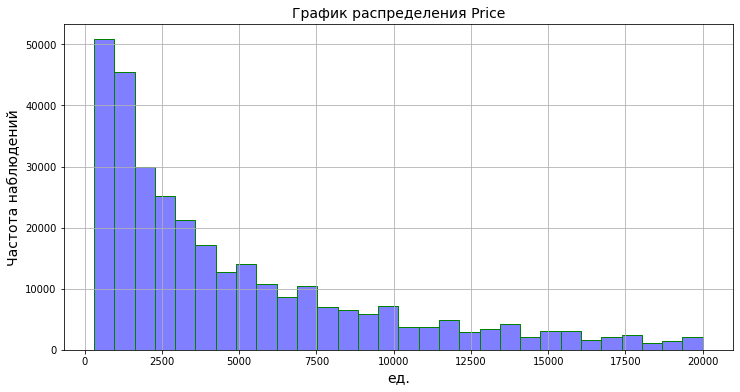

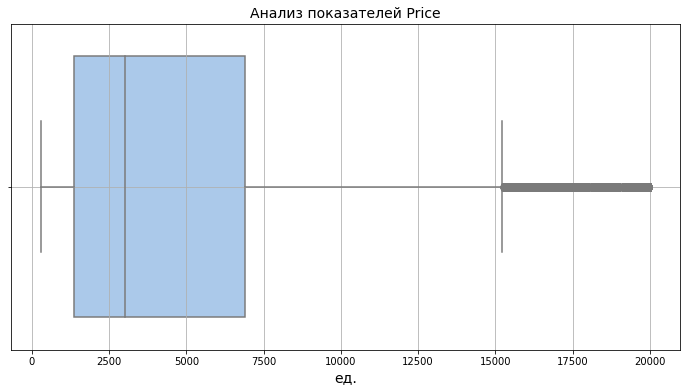

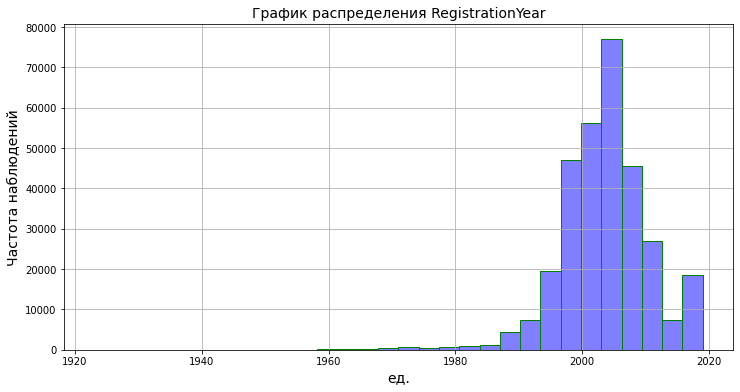

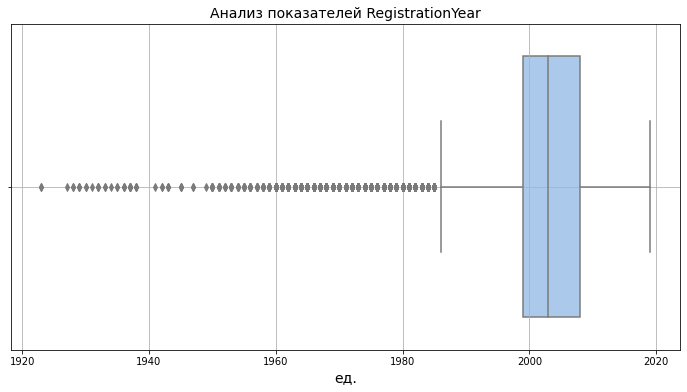

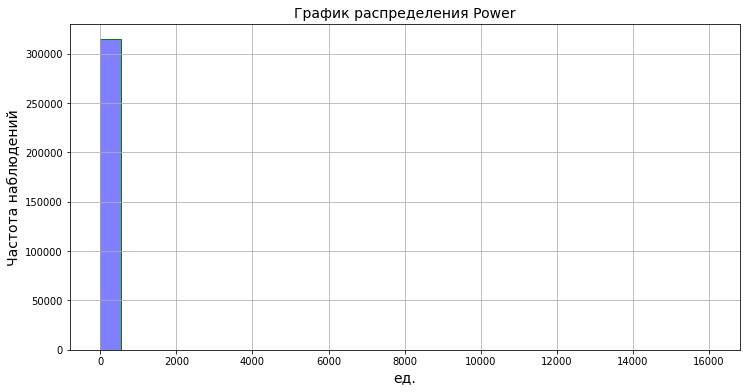

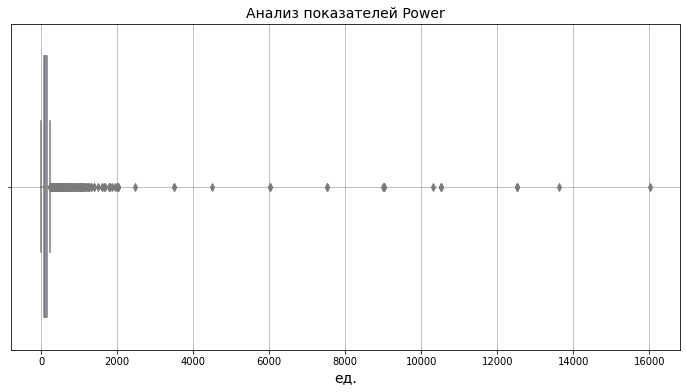

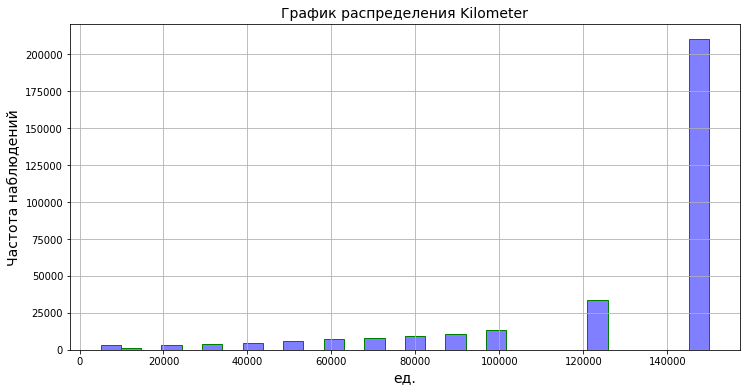

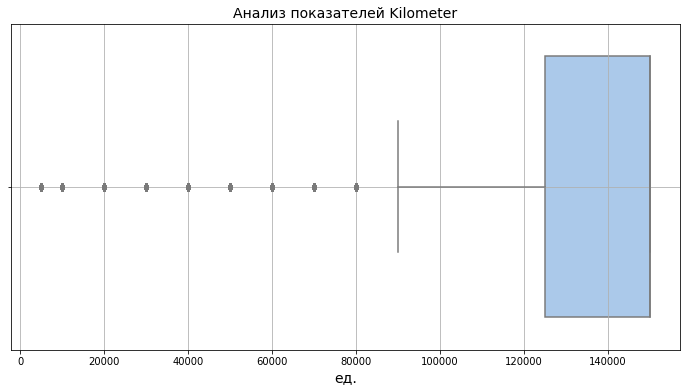

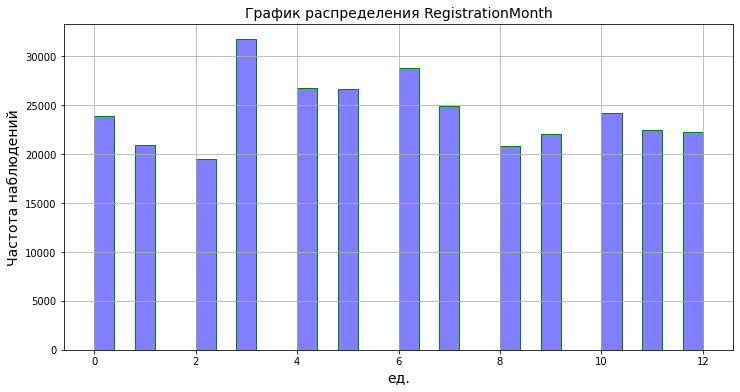

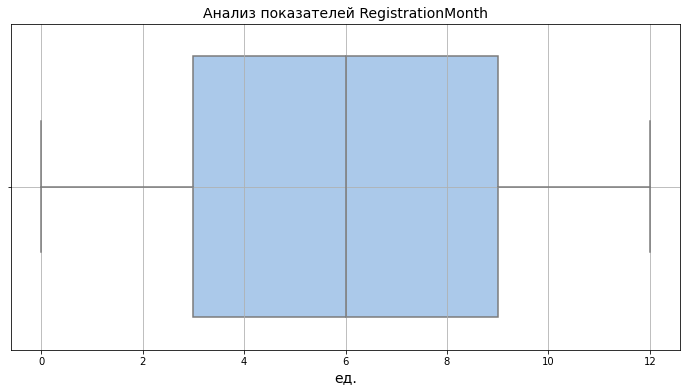

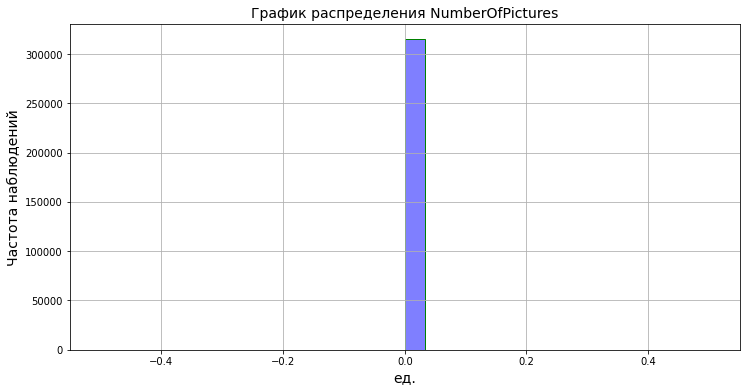

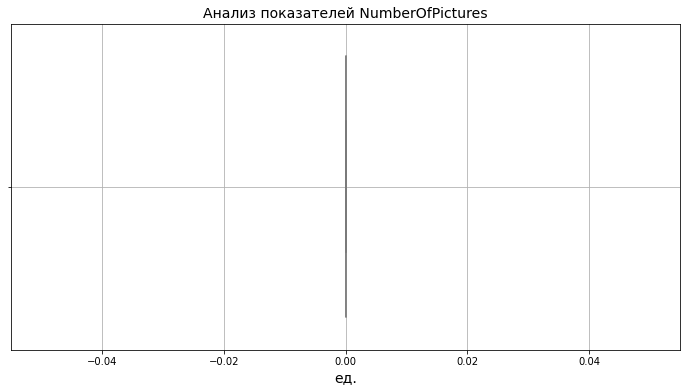

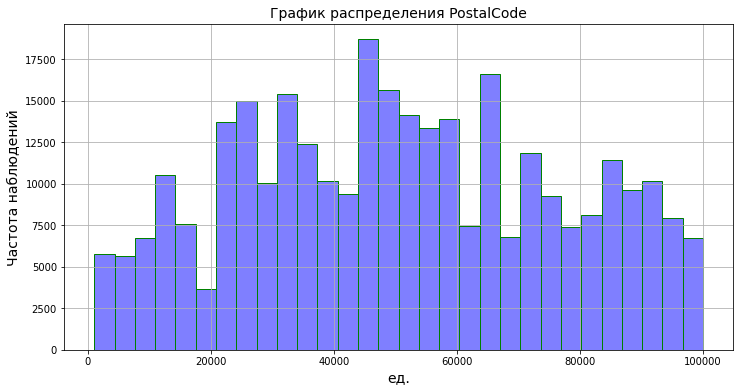

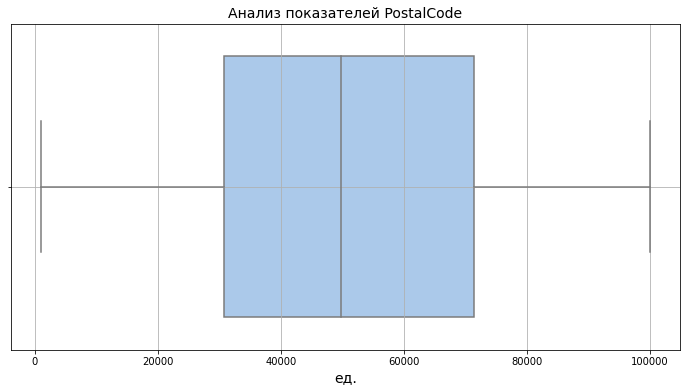

In [21]:
for i in num_list:
    hist(df_base, i, 30, i, 'ед.')
    box(df_base, i, i, 'ед.')

- График признака **Price** стремится к нормальному распределению со смещением влево. У нас имеются выбросы от 15000 до 20000, но такая ситуация вполне может встречаться в жизни. Большая часть значений сконцентрирована на промежутке от 0 до 2500.

- Признак **RegistrationYear** также распределяется нормально, но со смещением вправо, а выбросы с 1985 по 1925 могут встречаться в реальности, трогать не буду.

- **Power**: здесь сложно судить о распределении, присутствует довольно много выбросов и некорректных значений. Возможно, признак не сильно будет влиять на целевой, но это можно проверить уже только в корреляционном анализе. Наиболее часты показатели сконцентрированы в промежутке от 0 до 300 лошадиных сил.

- **Kilometer**: касательно пробега распределение нормальное со смещением вправо. Большая часть автомобилец с пробегом более 140000км, выбросы реальны.

- **RegistrationMonth**: распределение более похоже на кластеризацию, но четких вершин отследить не могу. 

- **NumberOfPictures**: данный признак более похож на ошибку выгрузки данных. Его при моделировании использовать не будем.

- **PostalCode**: здесь распределение также больше напоминает кластеризацию. Из каких городов чаще постят автомобили тоже сложно оценить, поскольку не знаю какой страны данный сервис и являются ли эти данные реальными. После корреляции можно будет принять решение об использовании данного признака при моделировании.

### Качественные признаки

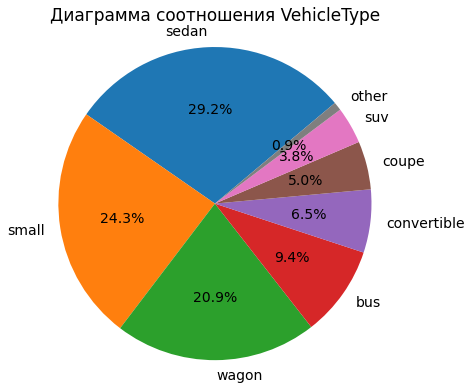

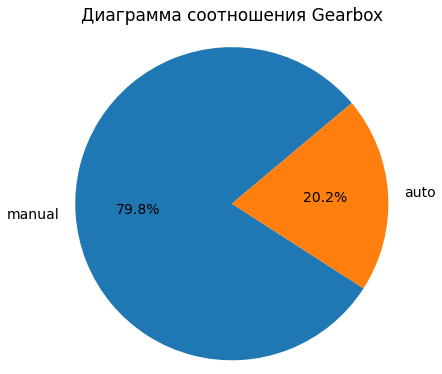

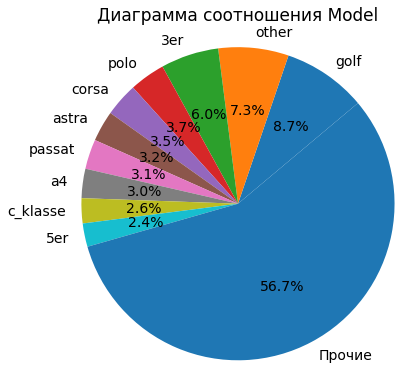

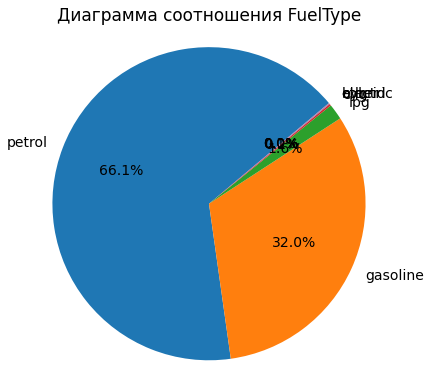

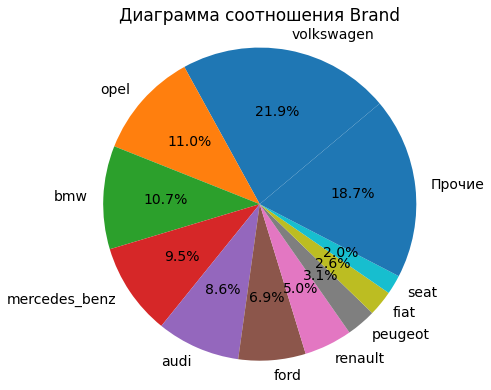

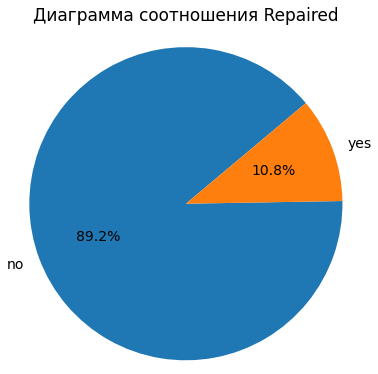

In [22]:
for i in cat_list:
    pie(df_base[i],i,40)

- **VehicleType**: в лидерах sedan 29%, small 25.1% и wagon 20.7%.

- **Gearbox**: здесь ручная коробка передач занимает аж 80.2% всех записей, когда автоматическая всего 19.8%.

- **Model**: соотношение моделей получилось неинформативным, разброс очень велик. Модели дублируют поведение распределения марок автомобилей. Например, у Фольксвагена в топе Golf, у БМВ 3 серия.

- **FuelType**: основаная часть бензиновых авто 66.9%, далее располагаются авто на газу 31.2%, дизельных на рынке совсем не видать почти.

- **Brand**: в топе брендов Фольксваген 21.9%, Опель 11.3%, БМВ 10.5%, Мерседес 9.3%, Ауди 8.4%.

- **Repaired**: 11.9% авто с ремонтом, тогда как без ремонта 88.1%.

### Выводы

- В данных встречаются выбросы, но они имеют место быть в реальной жизни, поэтому не стал их убирать;
- Чаще всего встречаются маломощные автомобили на ручной коробке передач с бензиyовым двигателем и ценой дешевле 2500 евро;
- Определились несколько неинформативных признаков, которые скорее всего не будут участвовать в моделировании.

## Корреляционный анализ данных

In [23]:
df_main = df_base.drop(['DateCrawled', 'NumberOfPictures', 'DateCreated', 'LastSeen'], axis=1).copy()
display(df_main.head(5))
num_list = df_main.select_dtypes(include='number').columns.to_list()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775


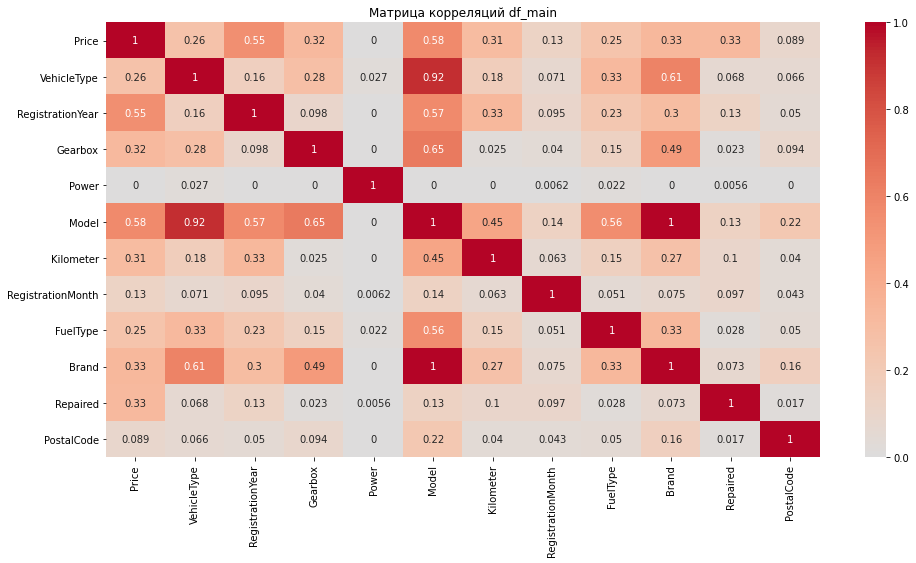

In [24]:
corr = df_main.phik_matrix(interval_cols=num_list)

plt.figure(figsize=(16,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций df_main')
plt.show()

**Price и Model**: показывают устойчивую зависимость 0.58, согласно которой увеличение стоимости зависит от модели автомобиля.

**Price и RegistrationYear**: также устойчивая зависимость 0.56, чем ближе год регистрации к актуальному, тем выше стоимость машины.

**Price и Repaired**: зависимость умеренная 0.37, не ремонтировался - цена часто выше.

**Price и Brand**: умеренная зависимость 0.34, чаще высокая стоимость у более популярных брендов.

**Price и Gearbox**: умеренная зависимость 0.33, с автоматической коробкой чаще автомобили стоят дороже.

**Price и Kilometer**: умеренная зависимость 0.31, здесь ситуация не очень ясна, вряд ли чем выше пробег - тем выше стоимость, проанализируем далее на графиках scatter.

**Price и FuelType**: слабая зависимость 0.26, стоимость автомобиля иногда зависит от вида топлива, думаю из жизни получится, что дизелиьные машины дороже остальных, далее идут бензиновые.

**Price и VehicleType**: слабая зависимость 0.27, думаю, что здесь больше играет связь бренда и модели. Также тяжелая техника всегда дороже, чем автомобили для повседневной езды.

--------------------------------------------------------------------------------------------------------------------------------

**Power и PostalCode** не показывают зависимости с целевым признаком, при моделировании их также рассматривать не будем.

**Model и Brand**: показывают между собой абсолютную зависимость 1.0, признаки полностью друг друга объясняют.

**Model и VehicleType**: ситуация та же 0.92 коэффициент, значит признаки также друг друга объясняют, что тоже логично.

In [25]:
def scatter(feature_first,feature_second):
    plt.figure(figsize=(12,8))
    sns.scatterplot(data=df_main, x=feature_first, y=feature_second, 
                    alpha=0.3, color='green', hue='Price', palette = 'coolwarm')
    plt.title(f'График распределения признаков относительно целевого', fontsize=14)
    plt.xlabel(f'{feature_first}', fontsize=14)
    plt.ylabel(f'{feature_second}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

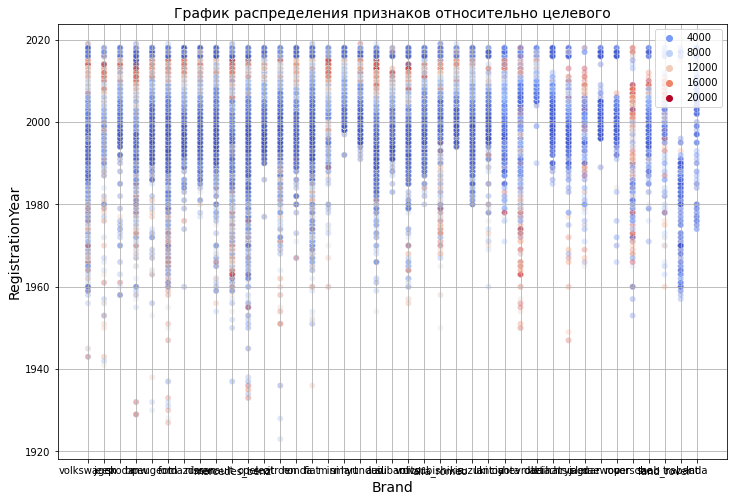

In [26]:
scatter('Brand', 'RegistrationYear')

**Бренд и Год регистрации неплохо показывают ценовую сегментацию. Чаще всего дорогие машины находятся в промежутке от 2010г до 2018г регистрации. Но есть и бренды, машины которых уже не производятся или имеют завышенную стоимость из-за интереса коллекционеров. Поэтому хорошо ценятся автомобили 60х - 80х годов.**

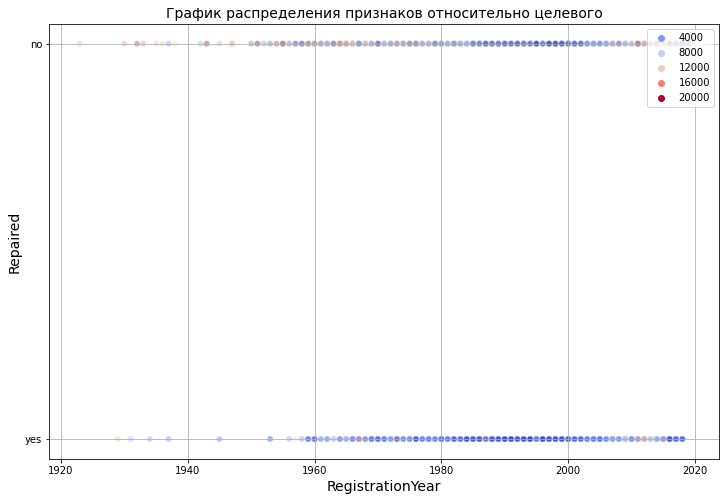

In [27]:
scatter('RegistrationYear','Repaired')

**Согласно статусу ремонта автомобиля и году регистрации видим ту же картину. Высоко ценятся раритетные авто и свежие машины без ремонтов**

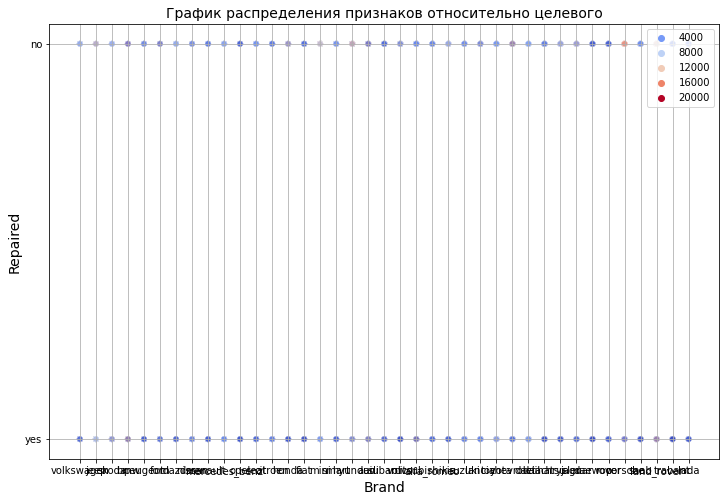

In [28]:
scatter('Brand','Repaired')

**Касательно статистики статуса ремонта и бренда автомобиля нет четкой картины, но есть отдельные фирмы (скорее всего уже коллекционные модели), который без ремонта ценятся дороже остальных**

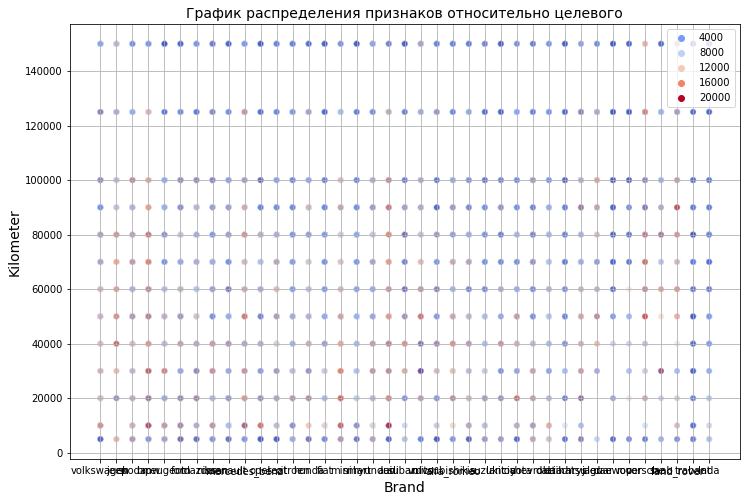

In [29]:
scatter('Brand','Kilometer')

**Тут тоже можно отметить определенные фирмы, типа Фольксвагена, где основные ценовые лидеры располагаются в промежутке от 10000 до 100000 пробега.**

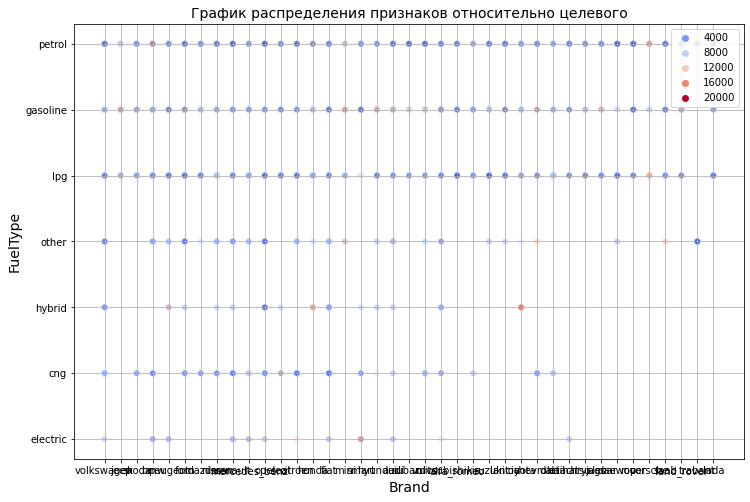

In [30]:
scatter('Brand', 'FuelType')

**Здесь картина следубщая: у части брендов (чаще всего) ценятся определенные комплектации в зависимости от износостойкости агрегата. Пример из реальности: у БМВ дизеля стоят на порядок выше бензиновых вариантов из-за экономичности и износостойкости мотора.**

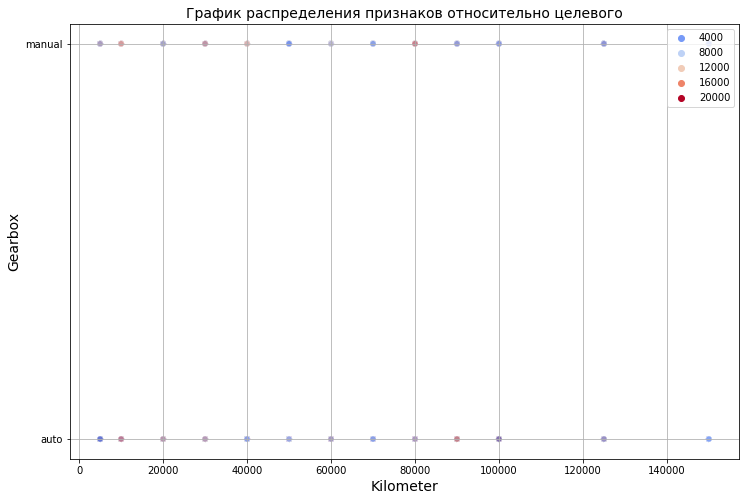

In [31]:
scatter('Kilometer', 'Gearbox')

**Между коробкой передач и пробегом есть некоторая интересная информация. На пробеге 10000 - 90000 у ручной кпп сконцетрированы практически все дорогие автомобили, тогда как у автоматической встречаются и на большем пробеге.**

### Выводы

- Наиболее определяющими стоимость признаками являются Model и RegistrationYear;
- Портрет бюджетного автомобиля: до 2010г выпуска, с ручной кпп, менее популярного бренда (например Ford), двигатель на газу с пробегом более 100000км.
- Портрет наиболее дорогостоящего автомобиля: с 2010 по 2020г, автоматическая кпп, Вольксваген/БМВ/Мерседес, двигатель дизель/бензин, пробег 10000-60000км.
- Отдельный портрет исключительных дорогостоящих вариантов: 1) либо старый раритетный авто без ремонтов в хорошем состоянии, представляющий высокую ценность у коллекционеров; 2) новый авто топовой модели люксовых брендов по типу Ferrari/Lamborghini/БМВ/Мерседес.

## Обработка признаков и обучение моделей

**Теперь сначала уберем оставшиеся неинтересные входные признаки для определения целевого. Далее попробуем применить сначала простые модели и посмотрим на базовые результаты**

In [32]:
df_pipe = df_main.drop(['PostalCode'], axis=1).copy()
df_pipe.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


### Реализация простых моделей

In [33]:
X = df_pipe.drop('Price', axis=1).copy()
y = df_pipe['Price'].copy()

X_train,X_test,y_train,y_test = train_test_split(X,
                                               y,
                                               random_state=RANDOM_STATE,
                                               test_size=TEST_SIZE)

**Сначала попробую определить лучшую модель методом Optuna**

In [34]:
num_features = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

unique_models = df_pipe['Model'].dropna().unique().tolist()
unique_brands = df_pipe['Brand'].dropna().unique().tolist()

def mo_graph(predictions, residuals):
    axes[0].hist(x=residuals, bins=20, color='skyblue', ec='black')
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    scatter = axes[1].scatter(x=predictions, y=residuals, c=residuals, cmap='viridis', edgecolor='k')
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    cbar = fig.colorbar(scatter, ax=axes[1])
    cbar.set_label('Значения остатков')

ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
ord_columns = ['Model', 'Brand']
num_columns = num_features

ohe_pipe = Pipeline([
    ('simpleImputerOhe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

ord_pipe = Pipeline([
    ('simpleImputerBeforeOrd', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[unique_models, unique_brands],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )),
    ('simpleImputerAfterOrd', SimpleImputer(strategy='most_frequent'))
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
])

def objective(trial):
    model_name = trial.suggest_categorical('model', ['DecisionTree','LinearRegression'])
    
    if model_name == 'DecisionTree':
        model = DecisionTreeRegressor(random_state=RANDOM_STATE)
        max_depth = trial.suggest_int('max_depth', 2, 10)
        model.set_params(max_depth=max_depth)
        
    else: 
        model = LinearRegression()

    pipeline = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', model)
    ])
    
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Лучшие параметры:", study.best_params)
print("Лучший результат RMSE:", -study.best_value)

[I 2025-02-12 14:17:33,262] A new study created in memory with name: no-name-6c665a9d-d080-4ee9-a7f2-ba91e499f1ab
[I 2025-02-12 14:17:38,677] Trial 0 finished with value: -3244.4739711320917 and parameters: {'model': 'LinearRegression'}. Best is trial 0 with value: -3244.4739711320917.
[I 2025-02-12 14:17:44,199] Trial 1 finished with value: -2345.8139324652684 and parameters: {'model': 'DecisionTree', 'max_depth': 6}. Best is trial 1 with value: -2345.8139324652684.
[I 2025-02-12 14:17:49,644] Trial 2 finished with value: -3244.4739711320917 and parameters: {'model': 'LinearRegression'}. Best is trial 1 with value: -2345.8139324652684.
[I 2025-02-12 14:17:55,309] Trial 3 finished with value: -2345.8139324652684 and parameters: {'model': 'DecisionTree', 'max_depth': 6}. Best is trial 1 with value: -2345.8139324652684.
[I 2025-02-12 14:18:01,707] Trial 4 finished with value: -2034.566210678789 and parameters: {'model': 'DecisionTree', 'max_depth': 10}. Best is trial 4 with value: -2034.

Лучшие параметры: {'model': 'DecisionTree', 'max_depth': 10}
Лучший результат RMSE: 2034.566210678789


**В результате получаем, что лучшей на тренировочной выборке стала модель DecisionTree('max_depth': 10), которая показала метрику RMSE 2034.57**

In [35]:
ohe_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
ord_columns = ['Model', 'Brand']
num_columns = num_features

ohe_pipe = Pipeline([
        ('simpleImputerOhe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ])
    
ord_pipe = Pipeline([
        ('simpleImputerBeforeOrd', SimpleImputer(strategy='most_frequent')),
        ('ord', OrdinalEncoder(
            categories=[unique_models,unique_brands],
            handle_unknown='use_encoded_value',
            unknown_value=-1
        )),
        ('simpleImputerAfterOrd', SimpleImputer(strategy='most_frequent')) 
    ])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
])

pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


param_distributions = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
] 

randomized_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    scoring='neg_root_mean_squared_error',  
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=5
)

randomized_search.fit(X_train, y_train)

print('Среднее RMSE по кросс-валидации:', -randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n', randomized_search.best_estimator_)

Среднее RMSE по кросс-валидации: 2034.566210678789

Лучшая модель и её параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputerOhe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Repaired']),
                                                 ('ord',
                                              

**RandomizedSearchCV метод ожидаемо сработал быстрее, чем Optuna, но он мог пропустить лучшую комбинацию. В нашем конкретном случае метод определил такую же лучшую модель с той же метрикой DecisionTreeRegressor(max_depth=10, random_state=42) RMSE = 2034.57**

In [36]:
result = pd.DataFrame(randomized_search.cv_results_)
result = result[
    ['mean_fit_time', 'mean_score_time', 'rank_test_score', 'mean_test_score', 'param_models', 'params']
].sort_values('rank_test_score').set_index('rank_test_score')
result['mean_test_score'] = result['mean_test_score']*(-1)
display(result)
best_model_work_time = result['mean_fit_time'][1]+result['mean_score_time'][1]
print(f"Время работы топовой модели: {round(best_model_work_time,2)} секунд")

,mean_fit_time,mean_score_time,mean_test_score,param_models,params
rank_test_score,,,,,
1,1.213939,0.093538,2034.566211,"DecisionTreeRegressor(max_depth=10, random_sta...","{'preprocessor__num': StandardScaler(), 'model..."
2,1.112840,0.090403,2085.048158,"DecisionTreeRegressor(max_depth=10, random_sta...","{'preprocessor__num': 'passthrough', 'models__..."
3,1.016715,0.090342,2231.911467,"DecisionTreeRegressor(max_depth=10, random_sta...","{'preprocessor__num': 'passthrough', 'models__..."
4,1.092183,0.092578,2231.938791,"DecisionTreeRegressor(max_depth=10, random_sta...","{'preprocessor__num': StandardScaler(), 'model..."
5,1.083243,0.112528,2345.813932,"DecisionTreeRegressor(max_depth=10, random_sta...","{'preprocessor__num': StandardScaler(), 'model..."
6,0.898961,0.092874,2484.975889,"DecisionTreeRegressor(max_depth=10, random_sta...","{'preprocessor__num': StandardScaler(), 'model..."
7,0.806626,0.089668,2669.335135,"DecisionTreeRegressor(max_depth=10, random_sta...","{'preprocessor__num': 'passthrough', 'models__..."
8,0.826699,0.208212,3244.473971,LinearRegression(),"{'preprocessor__num': StandardScaler(), 'model..."
8,0.887117,0.163266,3244.473971,LinearRegression(),"{'preprocessor__num': MinMaxScaler(), 'models'..."


Время работы топовой модели: 1.31 секунд


**RandomizedSearchCV метод показал, что с задачей из простых моделей лучше всего справляется DecisionTreeRegressor(max_depth=10, random_state=42), среднее время обучения - 1.20 сек., скорость предсказания - 0.10 сек.**

### Тестирование LightGBM

In [37]:
boost_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', lgb.LGBMRegressor(objective='regression', metric='rmse', random_state=RANDOM_STATE))
])

start_fit = time.time()
boost_pipeline.fit(X_train, y_train)
end_fit = time.time()
fit_time = round(end_fit - start_fit, 2)

start_pred_train = time.time()
train_preds = boost_pipeline.predict(X_train)
end_pred_train = time.time()
predict_time_train = round(end_pred_train - start_pred_train, 2)

rmse_train = mean_squared_error(y_train, train_preds, squared=False)

print(f'Время обучения: {fit_time} сек')
print(f'Время предсказания на тренировочной выборке: {predict_time_train} сек')
print(f'RMSE на тренировочной выборке: {rmse_train:.4f}')

Время обучения: 5.53 сек
Время предсказания на тренировочной выборке: 2.31 сек
RMSE на тренировочной выборке: 1702.0619


**LightGMB модель показывает лучшую метрику на тренировочной выборке RMSE = 1702.06, но время обучения 5.27 сек., а время предсказания 2.4 сек., что дольше, чем у простой модели Decision Tree.**

### Выводы

- Убрал оставшиеся признаки, не демонстрирующие зависимости с целевым признаком;
- Провел анализ базовых моделей (Линейная регрессия и Древо решений) для предсказания признака Price. Из них лучше всего справилась модель Древо решений и показателем метрики RMSE ~2034.57, что соответствует условиям технического задания. Среднее время обучения - 1.20 сек., скорость предсказания - 0.10 сек.
- Применив метод градиентного бустинга LightGBM, получил метрику лучше: RMSE 1702.06, но время обучения 5.27 сек., а время предсказания 2.4 сек., что дольше, чем у простой модели Decision Tree.

## Анализ лучшей модели и оценка работы на тестовой выборке

**С точки зрения критериев заказчика лучшей моделью станет обычное древо решений. Метрика соответствует условию, а скорость работы значительно превышает градиентный бустинг. Теперь проверим ее на тестовой выборке**

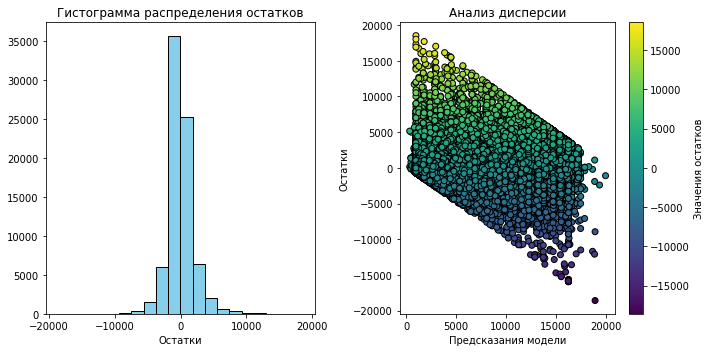

Значение RMSE для лучшей модели 2027.54


In [38]:
predictions = randomized_search.best_estimator_.predict(X_test)

residuals = y_test - predictions

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

mo_graph(predictions, residuals)

plt.tight_layout()
plt.show()

rmse = mean_squared_error(y_test, predictions, squared=False)
print(f'Значение RMSE для лучшей модели {rmse.round(2)}')

**Показатели модели на тестовой выборке даже незначительно лучше, чем на тренировочной. RMSE = 2027.54**

**Теперь проведем анализ моделей, начнем с SHAP метода интерпретации важности признаков на предсказания моделирования**

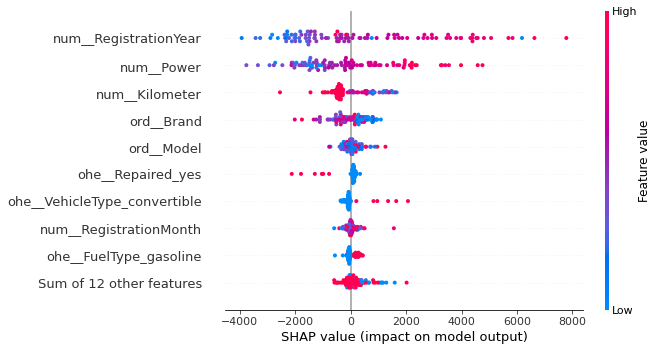

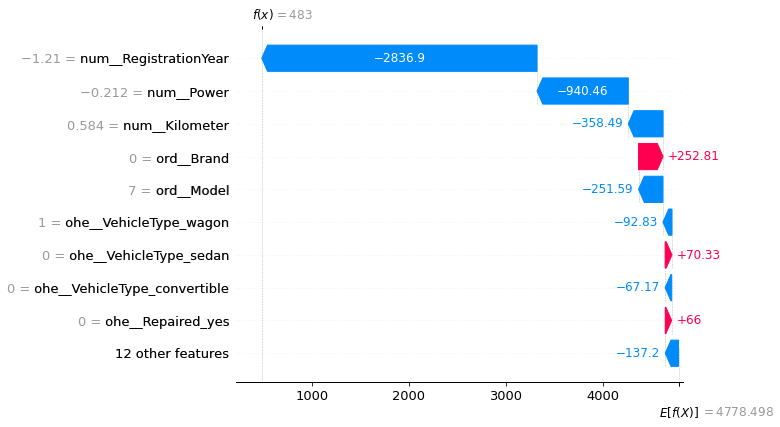

In [39]:
true_model = pipeline.named_steps['models']

X_train_preprocessed = data_preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(
    X_train_preprocessed, 
    columns=data_preprocessor.get_feature_names_out()
)

X_train_sampled = X_train_preprocessed.sample(n=100, random_state=RANDOM_STATE)
explainer_true = shap.TreeExplainer(true_model)
shap_values = explainer_true.shap_values(X_train_sampled)
shap_explanation = shap.Explanation(values=shap_values, base_values=explainer_true.expected_value, data=X_train_sampled)

shap.plots.beeswarm(shap_explanation)
shap.plots.waterfall(shap_explanation[0])

**Достаточно привести 1 пример распределения важности признаков для модели, поскольку DecisionTree - это основа для моего градиентного бустинга, который состоит из 100 деревьев в данном проекте.**

**Иерархия важности признаков для опеределения цены выглядит так:** 
1. RegistrationYear
2. Power
3. Kilometer
4. Brand
5. VehicleType
6. Gearbox
7. Repaired

**При этом наиболее чистое разделение придают признаки VehicleType, Gearbox, Repaired. Это отчетливо видно на первом графике.**

**На втором графике мы видим, как на решение модели более всего повлиял Год регистрации авто и Мощность автомобиля, уменьшив итоговую стоимость в предсказании.**

**Мы видели при анализе корреляции, что лошадиные силы не показывают глобальной зависимости к ценам разных автомобилей. Более того, мощность влияет больше на налогооблажение после приобретения автомобиля, тогда как объем двигателя напрямую влияет на стоимость, поскольку в большинстве стран именно по данному критерию выстраиваются налоговые пошлины. Авто одной модели, но с разными объемами двигателя могут очень существенно различаться по цене.**

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable Model for analysis 1. Dropping this column
  warnings.warn(


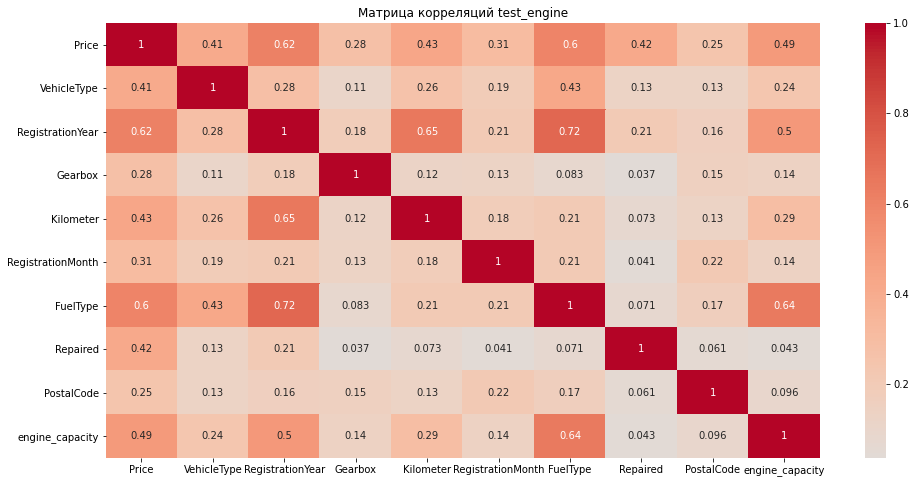

In [40]:
test_engine = df_main.copy()
test_engine = test_engine[(test_engine['Brand'] == 'bmw') & 
                          (test_engine['Model'] == '3er') & 
                          (test_engine['RegistrationYear'] >= 2010) &
                          (test_engine['Power'] > 100)]
test_engine['engine_capacity'] = 0.0
for index, row in test_engine.iterrows():
    if row['Power'] < 170:
        test_engine.loc[index, 'engine_capacity'] = 1.6
    elif row['Power'] > 170 and row['Power'] < 280:
        test_engine.loc[index, 'engine_capacity'] = 2.0
    else:
        test_engine.loc[index, 'engine_capacity'] = 3.0
    
test_engine = test_engine.drop(['Power', 'Brand'], axis=1)

        
corr_check=test_engine.phik_matrix(interval_cols = ['Price',
                                                    'RegistrationYear',
                                                    'Kilometer',
                                                    'RegistrationMonth',
                                                    'PostalCode',
                                                    'engine_capacity'])
plt.figure(figsize=(16,8))
sns.heatmap(corr_check, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций test_engine')
plt.show()

**Здесь тестовый пример того, как новый признак объема двигателя довольно сильно влияент на цену с показателем сонаправленной корреляции 0.49. Нет уверенности, что я абсолютно верно присвоил значения, но расчет был внутри БМВ модели 3 серии в кузове F30 и далее, что соответствует реальным комплектациям моделей. К тому же, гораздо больше людей знают объем своего мотора, чем его мощность. Я уверен, что с более точными данными зависимость между признаками будет только увеличиваться!**

**Данные о литраже брал согласно официальным характеристикам моделей f30/f31 и с небольшой погрешностью на ошибку владельца авто**
- BMW 316i 1.6л 116л.с.
- BMW 320i/320d 2.0л 180л.с.
- BMW 328i 2.0л 240л.с.
- BMW 330i 2.0л 258л.с.
- BMW 340i 3.0л 326л.с.

**Так или иначе, задача проекта выполнена и лучшей моделью, отвечающей критериям заказчика, становится модель DecisionTreeRegressor с гиперпараметрами max_depth=10, random_state=42. Это позволит достигать положенной точности (в данном случае метрика ошибок составляет ~2027), среднее время обучения - 1.20 сек., а скорость предсказания - 0.10 сек.**

## Заключение

**Задачей данного проекта явлалось создание модели для предсказания стоимости автомобиля, исходя из предоставленной информации клиентом. Важными критериям была скорость работы и точность предсказаний со значением метрики ошибок RMSE не более 2500**

**В результате исследования при одинаковой важности критериев скорости работы и точности предсказаний лучше себя показывает простая модель DecisionTreeRegressor с гиперпараметрами max_depth=10, random_state=42., среднее время обучения которой - 1.20 сек., а скорость предсказания - 0.10 сек.**

**Портреты автомобилей в ходе исследовательской работы над проектом:**
- Портрет бюджетного автомобиля: до 2010г выпуска, с ручной кпп, менее популярного бренда (например Ford), двигатель на газу с пробегом более 100000км.
- Портрет наиболее дорогостоящего автомобиля: с 2010 по 2020г, автоматическая кпп, Фольксваген/БМВ/Мерседес, двигатель дизель/бензин, пробег 10000-60000км.
- Отдельный портрет исключительных дорогостоящих вариантов: 1) либо старый раритетный авто без ремонтов в хорошем состоянии, представляющий высокую ценность у коллекционеров; 2) новый авто топовой модели люксовых брендов по типу Ferrari/Lamborghini/БМВ/Мерседес.

**Для поиска лучшей базовой модели был выбран метод RandomizedSearchCV, поскольку позволяет рассмотреть большое количество комбинаций в короткий срок и дать более менее точные результаты.**

**Данные в изначальных таблицах были распределены нормально, часть пропусков, янвых дубликатов и аномалий было очищено. Провел исследовательский и корреляционный анализ признаков.**